In [1]:
import numpy as np
import scipy
import scipy.stats
import sklearn
import sklearn.preprocessing
import sklearn.linear_model

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

date = '12_16_19' # change this to get today's date

# Directory containing the motif scanning results.
motif_input_dir = '../motif_scanning_results/'
file_prefix = 'leiomyoma_HOSVD_final'
output_dir = '../'


In [2]:
# Read in the names of the motifs. This is just a list of
# motif names that match the columns in the motif calling
# matrix described below.
motif_names = np.loadtxt(motif_input_dir + file_prefix + '_motif_scan_ATACseq_pos_loc4/names', dtype=str, delimiter="\t")
# From the motif names obtain the gene symbol for the
# corresponding transcription factor.
TF_names = []
for motif in motif_names:
    TF_names.append(motif.replace('HOCOMOCO_','').replace('.coverage',''))

# Read in the motif calling result for each set of regions.
# The motif calling results are stored as a CSV file with
# each region corresponding to a row and the comma separated
# columns to the result for the corresponding motif following
# the order given in motif names. The value corresponds to the
# number of hits for the motif in the sequence, or to a binary
# call for whether there was a motif hit or not.
count_matrix_myo = np.loadtxt(motif_input_dir + file_prefix + '_motif_scan_ATACseq_pos_loc4/coverage_data.csv', dtype=np.int, delimiter=",")
count_matrix_leio = np.loadtxt(motif_input_dir + file_prefix + '_motif_scan_ATACseq_neg_loc4/coverage_data.csv', dtype=np.int, delimiter=",")

print(count_matrix_myo.shape)
print(count_matrix_leio.shape)

# Binarize the count matrix. A value of 1 indicates the
# motif was found in the sequence and a value of 0 
# indicates that it was not
binary_myo = np.clip(count_matrix_myo, 0, 1)
binary_leio = np.clip(count_matrix_leio, 0, 1)

(768, 317)
(1250, 317)


In [3]:
## Motif enrichment

In [4]:
# Use Fisher's exact test to test for non-independence
# of the presence of a motif and the condition in which
# the sequence has higher activating marks; The set of
# sequences the motif is enriched in is determined using
# the odds ratio

motif_enrichment_pvalue = [1.0 for i in range(len(motif_names))]
odds_ratio = [0.0 for i in range(len(motif_names))]
for i in range(len(motif_names)):
    table = [[len(np.where(binary_myo[:,i] == 1)[0]), len(np.where(binary_myo[:,i] == 0)[0])],
             [len(np.where(binary_leio[:,i] == 1)[0]), len(np.where(binary_leio[:,i] == 0)[0])]]
    odds_ratio[i], motif_enrichment_pvalue[i] = scipy.stats.fisher_exact(table, alternative='two-sided')

In [5]:
# Benjamini-Hochberg multiple hypothesis test correction 
alpha = 1e-3 # control FDR at this level
sorted_pvalue_index = np.argsort(motif_enrichment_pvalue)
for i in range(len(motif_enrichment_pvalue)):
    if( motif_enrichment_pvalue[sorted_pvalue_index[i]] <=
        alpha*(i+1)/len(motif_enrichment_pvalue) ):
        continue
    else:
        K = i
        print(K)
        break

# Get the adjusted p_value sorted by the p-value order
sorted_adj_pvalue = [motif_enrichment_pvalue[sorted_pvalue_index[i]]*(len(motif_enrichment_pvalue)/(i+1))
                     for i in range(len(motif_enrichment_pvalue))]

44


In [6]:
# TFs with motifs enriched in the regions with lower
# activating histone modifications in leiomyoma
for i in range(K):
    if(odds_ratio[sorted_pvalue_index[i]] > 1.0):
        print("{0}\t{1:.2e}\t{2:.2f}".format(TF_names[sorted_pvalue_index[i]],
                                      sorted_adj_pvalue[i],
                                      odds_ratio[sorted_pvalue_index[i]]))

ETV4	1.58e-08	1.81
MECP2	5.49e-06	1.80
ETV5	5.24e-06	1.62
ETS1	1.10e-05	2.06
ERG	1.74e-05	1.82
RARG	5.51e-05	1.70
SREBF2	6.08e-05	1.55
ETV1	7.06e-05	1.99
KLF6	7.94e-05	1.68
ELF3	9.05e-05	2.22
SP4	1.01e-04	1.74
NR1D1	1.08e-04	1.60
SP3	1.46e-04	1.69
IRF2	1.67e-04	23.19
RXRA	1.60e-04	1.56
E2F6	1.67e-04	1.61
IRF1	1.63e-04	4.83
ELF2	1.73e-04	1.86
EGR1	1.73e-04	1.64
KLF5	2.32e-04	1.77
ZBTB17	2.26e-04	1.60
KLF3	2.28e-04	1.77
ETS2	2.52e-04	1.49
NR3C1	3.03e-04	1.86
PATZ1	3.40e-04	1.64
TAF1	4.24e-04	1.58
VEZF1	4.84e-04	1.59
NR2F2	4.92e-04	1.75
E2F4	6.13e-04	1.59
NFIC	6.24e-04	1.63
STAT1	6.45e-04	3.76
PGR	6.67e-04	1.75
TFDP1	7.02e-04	1.58
SMAD3	7.28e-04	1.46


In [7]:
# TFs with motifs enriched in the regions with higher
# activating histone modifications in leiomyoma
for i in range(K):
    if(odds_ratio[sorted_pvalue_index[i]] < 1.0):
        print("{0}\t{1:.2e}\t{2:.2f}".format(TF_names[sorted_pvalue_index[i]],
                                      sorted_adj_pvalue[i],
                                      np.log(odds_ratio[sorted_pvalue_index[i]])))

SRF	4.39e-15	-2.53
HOXA9	4.95e-12	-1.00
TBP	4.63e-11	-0.69
HOXC9	5.46e-09	-0.75
HOXA10	2.07e-08	-0.89
MEIS1	5.45e-08	-0.81
CDX1	1.22e-07	-0.62
HOXA13	2.48e-05	-0.60
SOX5	1.44e-04	-0.43
HOXB7	5.86e-04	-1.21


In [8]:
## Sequence based logistic regression classification 

In [9]:
# Get the class labels for each of the sequences.
class_myo = np.ones(binary_myo.shape[0], dtype=np.int8)
class_leio = np.zeros(binary_leio.shape[0], dtype=np.int8)
full_class = np.concatenate((class_leio, class_myo), axis=0)
del class_myo, class_leio

# Concatenate the binary matrices to get the full
# predictor matrix
full_binary_matrix = np.concatenate((binary_leio, binary_myo), axis=0)


In [10]:
# Use 5-fold cross validation with a grid search to choose 
# the L1 regularization parameter lambda.
# Range of values to try
lambda_list = [0.01*(i+1) for i in range(100)]
CV_reg_pair = []

n_splits = 5
skf = sklearn.model_selection.StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=True)

for l_r in lambda_list:
    # Calculate the class balanced loss and accuracy on
    # the test set for each value of lambda
    avg_loss = 0.0
    avg_CV = 0.0
    skl_loss = 0.0
    for train_index, test_index in skf.split(full_binary_matrix, full_class):
        X_train, X_test = full_binary_matrix[train_index], full_binary_matrix[test_index]
        Y_train, Y_test = full_class[train_index], full_class[test_index]
        clf = sklearn.linear_model.LogisticRegression(penalty='l1', C=l_r, solver='liblinear',
                                                      class_weight='balanced').fit(X_train, Y_train)


        class_weight = len(Y_test)/(2 * np.bincount(Y_test))
        predicted = clf.predict_log_proba(X_test)
        # The loss function on the test set without the L1 regularization term
        loss = (-1.0/len(Y_test))*sum([class_weight[Y_test[i]]*((1-Y_test[i])*predicted[i,0] + Y_test[i]*predicted[i,1]) for i in range(len(Y_test))])
        avg_loss += loss/n_splits
    
        avg_CV += sklearn.metrics.balanced_accuracy_score(Y_test, clf.predict(X_test))/n_splits        

        total_count = [0.0, 0.0]
        correct_count = [0.0, 0.0]
    CV_reg_pair.append((l_r, avg_loss, avg_CV))

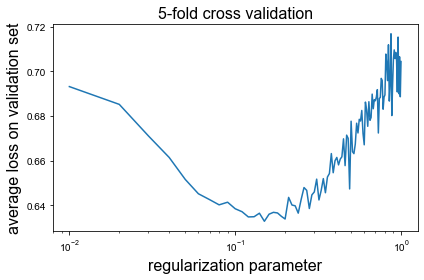

In [11]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)    

l1, = ax1.plot([CV_reg_pair[i][0] for i in range(len(CV_reg_pair))],
               [CV_reg_pair[i][1] for i in range(len(CV_reg_pair))])

plt.xscale('log')
ax1.set_xlabel('regularization parameter',fontsize=16)
ax1.set_ylabel('average loss on validation set',fontsize=16)
plt.title('5-fold cross validation',fontsize=16)
plt.tight_layout()

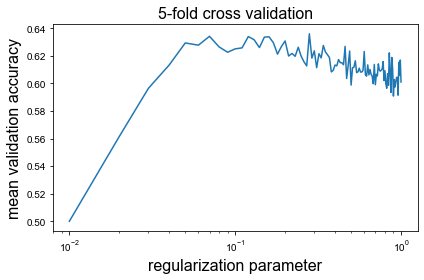

In [12]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)    

l1, = ax1.plot([CV_reg_pair[i][0] for i in range(len(CV_reg_pair))],
               [CV_reg_pair[i][2] for i in range(len(CV_reg_pair))])

plt.xscale('log')
ax1.set_xlabel('regularization parameter',fontsize=16)
ax1.set_ylabel('mean validation accuracy',fontsize=16)
plt.title('5-fold cross validation',fontsize=16)
plt.tight_layout()

In [13]:
# Select the regularization parameter that minimizes the mean
# log-loss on the test set
print(np.argmin([CV_reg_pair[i][1] for i in range(len(CV_reg_pair))]))
print(CV_reg_pair[np.argmin([CV_reg_pair[i][1] for i in range(len(CV_reg_pair))])])
l_fr = CV_reg_pair[np.argmin([CV_reg_pair[i][1] for i in range(len(CV_reg_pair))])][0]

14
(0.15, 0.6328517465947989, 0.6335506323741619)


In [14]:
# Now perform repeated random sampling and fit the
# logistic regression using the parameter found
# from the grid search. At each iteration the model
# is fit on 80% of the data and then tested on the 
# remaining 20%. The average training and test
# accuracies are reported.
avg_CV = 0.0
avg_train = 0.0
n_iter = 500
for i in range(n_iter):
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(full_binary_matrix, full_class, test_size = 0.2)

    clf = sklearn.linear_model.LogisticRegression(penalty='l1', C=l_fr, class_weight='balanced',
                                                  solver='liblinear').fit(X_train, Y_train)

    predicted = clf.predict_log_proba(X_test)
    
    # Get the class balanced test and training accuracies
    avg_CV += sklearn.metrics.balanced_accuracy_score(Y_test, clf.predict(X_test))/n_iter
    avg_train += sklearn.metrics.balanced_accuracy_score(Y_train, clf.predict(X_train))/n_iter
    
print("Mean CV training accuracy: ", avg_train)
print("Mean CV test accuracy    : ", avg_CV)

Mean CV training accuracy:  0.6781831006541278
Mean CV test accuracy    :  0.6251966665071224


In [15]:
# Fit the model on the entire data set. This is used
# To identify the motifs with greatest regression
# coefficients.
clf = sklearn.linear_model.LogisticRegression(penalty='l1', C=l_fr, 
                                              class_weight='balanced',
                                              solver='liblinear').fit(full_binary_matrix,
                                                                      full_class)
print("Full training accuracy: ",
      sklearn.metrics.balanced_accuracy_score(full_class, clf.predict(full_binary_matrix)))

Full training accuracy:  0.6759625


In [16]:
# Transcription factors with the 10 most positive
# regression coefficients (predicting lower histone
# modifications in leiomyoma)
print("Predict lower in leiomyoma")
for i in range(10):
    print("{0}\t{1:.2f}".format(TF_names[np.argsort(clf.coef_[0])[-i-1]],
                                np.sort(clf.coef_[0])[-i-1]))

Predict lower in leiomyoma
NR3C1	0.38
IRF1	0.33
ETV4	0.32
ELF3	0.32
NR2F2	0.28
STAT1	0.27
PGR	0.23
NR1D1	0.23
GATA4	0.22
DBP	0.19


In [17]:
# Transcription factors with the 10 most negative
# regression coefficients (predicting higher histone
# modifications in leiomyoma)
print("Predict higher in leiomyoma")
for i in range(10):
    print("{0}\t{1:.2f}".format(TF_names[np.argsort(clf.coef_[0])[i]],
                                np.sort(clf.coef_[0])[i]))

Predict higher in leiomyoma
SRF	-1.52
HOXA9	-0.60
TBP	-0.42
ARNTL	-0.31
HOXC9	-0.31
HOXA10	-0.27
CDX1	-0.24
ZNF335	-0.22
NFYC	-0.19
NKX3-2	-0.18


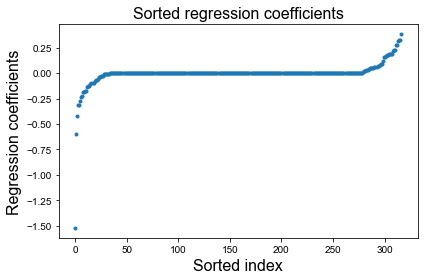

In [18]:
# Plot the regression coefficients
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)    

l1, = ax1.plot(np.sort(clf.coef_[0]),'.')

ax1.set_xlabel('Sorted index',fontsize=16)
ax1.set_ylabel('Regression coefficients',fontsize=16)
plt.title('Sorted regression coefficients',fontsize=16)
plt.tight_layout()